In [4]:
# 1. Importy bibliotek
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 2. Ustawienie urządzenia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Używane urządzenie: {device}')

# 3. Główne parametry
BATCH_SIZE = 64
IMAGE_SIZE = 224

# 4. Ścieżki do danych
DATA_DIR = '../tiny-imagenet-200/' 

# 5. Ścieżka bazowa do zapisu wyników
BASE_RESULTS_DIR = './wyniki'
os.makedirs(BASE_RESULTS_DIR, exist_ok=True)


Używane urządzenie: cuda


In [5]:
# 6. Definicja transformacji

# Transformacje dla danych treningowych (augmentacje)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Transformacje dla danych walidacyjnych i testowych (bez augmentacji)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE + 32),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [6]:
# 7. Wczytanie danych

# Ścieżki
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')  # Używamy już poprawnie uporządkowanej walidacji!

# Dataset treningowy
train_dataset = torchvision.datasets.ImageFolder(
    root=train_dir,
    transform=train_transform
)

# Dataset walidacyjny
val_dataset = torchvision.datasets.ImageFolder(
    root=val_dir,
    transform=test_transform
)

# DataLoadery
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Liczba klas: {len(train_dataset.classes)}")
print(f"Liczba próbek treningowych: {len(train_dataset)}")
print(f"Liczba próbek walidacyjnych: {len(val_dataset)}")


Liczba klas: 200
Liczba próbek treningowych: 100000
Liczba próbek walidacyjnych: 10000


In [11]:
# Funkcja do odwrócenia normalizacji (dla wyświetlania obrazów)
def imshow(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # odwrócenie normalizacji
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')


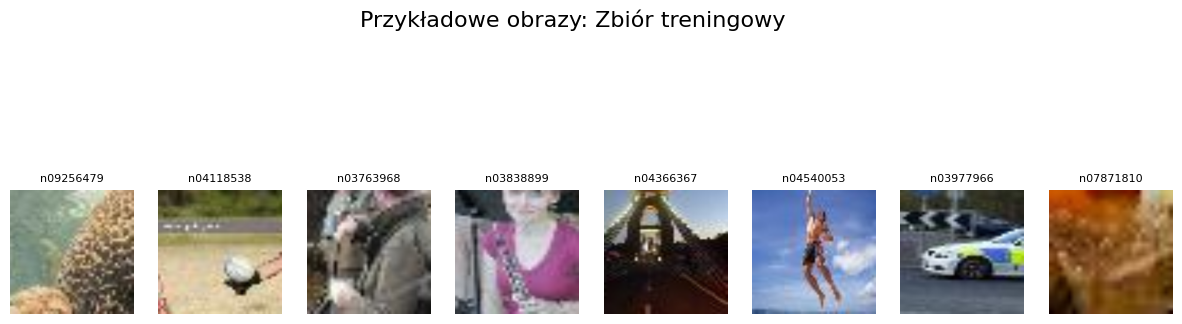

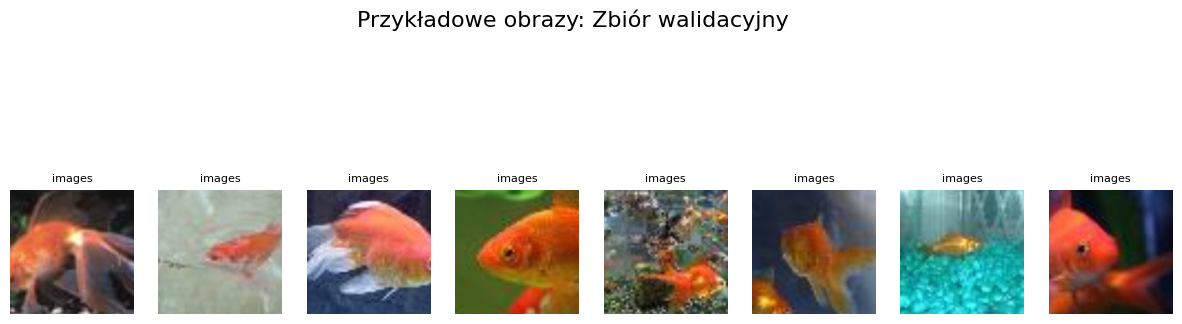

In [12]:
# Wyświetlanie przykładowych obrazków z loadera

def show_batch(dataloader, dataset_name, classes, num_images=8):
    images, labels = next(iter(dataloader))

    plt.figure(figsize=(15,5))
    for idx in range(num_images):
        plt.subplot(1, num_images, idx+1)
        imshow(images[idx])
        plt.title(classes[labels[idx].item()], fontsize=8)
        plt.axis('off')
    plt.suptitle(f'Przykładowe obrazy: {dataset_name}', fontsize=16)
    plt.show()

# Wyświetl przykłady z train_loader
show_batch(train_loader, 'Zbiór treningowy', train_dataset.classes, num_images=8)

# Wyświetl przykłady z val_loader
show_batch(val_loader, 'Zbiór walidacyjny', val_dataset.classes, num_images=8)


In [9]:
from tqdm import tqdm
import pandas as pd

def evaluate_model(model, dataloader, device, model_name, save_dir):
    model.eval()  # Tryb ewaluacji
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc=f'Ewaluacja: {model_name}', leave=False)

    with torch.no_grad():
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Aktualizacja paska postępu
            current_accuracy = 100 * correct / total
            progress_bar.set_postfix({'Accuracy': f'{current_accuracy:.2f}%'})

    accuracy = 100 * correct / total
    print(f'Accuracy ({model_name}): {accuracy:.2f}%')

    # Tworzenie folderu na wyniki (jeśli nie istnieje)
    os.makedirs(save_dir, exist_ok=True)

    # Zapis wyniku do pliku CSV
    results_path = os.path.join(save_dir, 'test_results.csv')
    df = pd.DataFrame({'model': [model_name], 'accuracy': [accuracy]})
    df.to_csv(results_path, index=False)

    return accuracy


In [10]:
# Import modeli
from torchvision import models

# Lista modeli
model_list = [
    ('vgg16', models.vgg16(weights='IMAGENET1K_V1')),
    ('resnet50', models.resnet50(weights='IMAGENET1K_V1')),
    ('mobilenet_v2', models.mobilenet_v2(weights='IMAGENET1K_V1')),
    ('efficientnet_b0', models.efficientnet_b0(weights='IMAGENET1K_V1')),
]

# Funkcja do podmiany ostatniej warstwy na 200 klas
def modify_model(model, model_name):
    if model_name.startswith('vgg'):
        model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 200)
    elif model_name.startswith('resnet'):
        model.fc = torch.nn.Linear(model.fc.in_features, 200)
    elif model_name.startswith('mobilenet') or model_name.startswith('efficientnet'):
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 200)
    else:
        raise ValueError(f'Nieobsługiwany model: {model_name}')
    return model

# Pętla testująca wszystkie modele
for model_name, model in model_list:
    print(f'\nTestowanie modelu: {model_name}')
    model = modify_model(model, model_name)
    model = model.to(device)

    accuracy = evaluate_model(
        model=model,
        dataloader=val_loader,
        device=device,
        model_name=model_name,
        save_dir=os.path.join(BASE_RESULTS_DIR, model_name)
    )



Testowanie modelu: vgg16


Accuracy (vgg16): 0.00%

Testowanie modelu: resnet50


Accuracy (resnet50): 0.00%

Testowanie modelu: mobilenet_v2


Accuracy (mobilenet_v2): 0.08%

Testowanie modelu: efficientnet_b0


Accuracy (efficientnet_b0): 0.03%


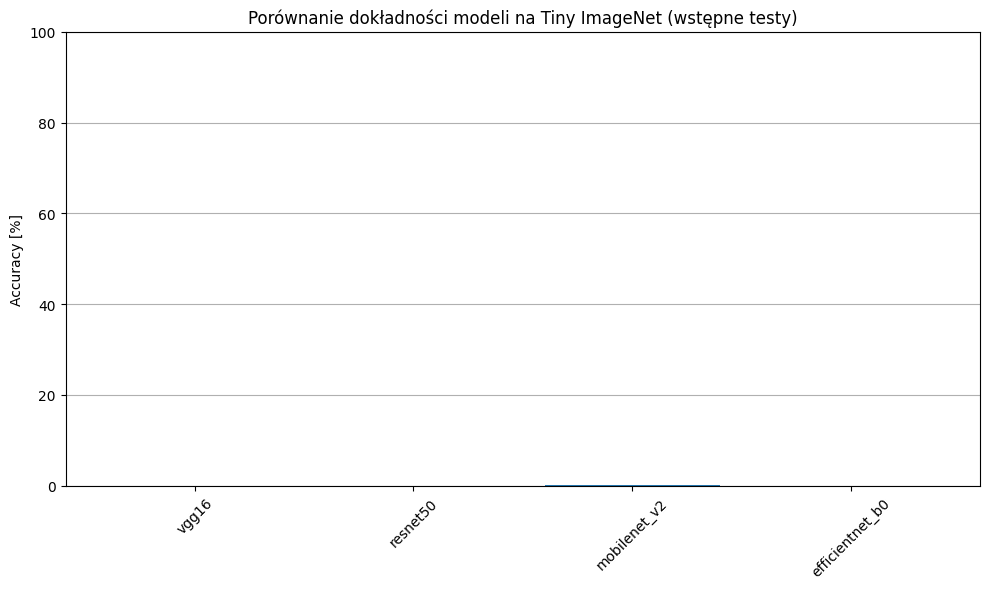

Wykres zapisany do: ./wyniki\wynik_porownanie.png


In [13]:
# 8. Tworzenie wykresu porównawczego modeli

import matplotlib.pyplot as plt
import pandas as pd

# Zbieranie wyników
accuracies = []
model_names = []

for model_name, _ in model_list:
    results_path = os.path.join(BASE_RESULTS_DIR, model_name, 'test_results.csv')
    if os.path.exists(results_path):
        df = pd.read_csv(results_path)
        model_names.append(model_name)
        accuracies.append(df['accuracy'].values[0])
    else:
        print(f'Brak wyników dla modelu: {model_name}')

# Tworzenie wykresu
plt.figure(figsize=(10,6))
plt.bar(model_names, accuracies)
plt.ylabel('Accuracy [%]')
plt.title('Porównanie dokładności modeli na Tiny ImageNet (wstępne testy)')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(axis='y')

# Zapis wykresu
os.makedirs(BASE_RESULTS_DIR, exist_ok=True)
plot_path = os.path.join(BASE_RESULTS_DIR, 'wynik_porownanie.png')
plt.tight_layout()
plt.savefig(plot_path)
plt.show()

print(f'Wykres zapisany do: {plot_path}')


Fine Tuning Klasyfiktora

In [14]:
def freeze_feature_extractor(model, model_name):
    if model_name.startswith('vgg'):
        for param in model.features.parameters():
            param.requires_grad = False
    elif model_name.startswith('resnet') or model_name.startswith('convnext'):
        for name, param in model.named_parameters():
            if "fc" not in name:
                param.requires_grad = False
    elif model_name.startswith('mobilenet') or model_name.startswith('efficientnet'):
        for name, param in model.named_parameters():
            if "classifier" not in name:
                param.requires_grad = False
    elif model_name.startswith('deit'):
        for name, param in model.named_parameters():
            if "head" not in name:
                param.requires_grad = False
    else:
        raise ValueError(f'Nieobsługiwany model: {model_name}')
    return model


In [15]:
from tqdm import tqdm

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs, patience, save_dir):
    train_loader, val_loader = dataloaders

    best_acc = 0.0
    best_model_wts = None
    train_loss_history = []
    val_acc_history = []
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'\nEpoka {epoch+1}/{num_epochs}')
        model.train()

        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc='Trening', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)

        # Ewaluacja
        val_acc = evaluate_model(model, val_loader, device)
        val_acc_history.append(val_acc)

        print(f'Loss: {epoch_loss:.4f} | Accuracy: {val_acc:.2f}%')

        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Wczesne zatrzymanie: brak poprawy przez {patience} epok.')
            break

    # Załaduj najlepsze wagi
    model.load_state_dict(best_model_wts)

    # Zapisywanie historii
    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, 'train_loss.npy'), np.array(train_loss_history))
    np.save(os.path.join(save_dir, 'val_accuracy.npy'), np.array(val_acc_history))

    return model, train_loss_history, val_acc_history


In [16]:
def plot_training_curves(train_loss, val_acc, save_dir):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, label='Train Loss')
    plt.xlabel('Epoka')
    plt.ylabel('Loss')
    plt.title('Train Loss')

    plt.subplot(1,2,2)
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoka')
    plt.ylabel('Accuracy [%]')
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.legend()
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, 'train_loss_accuracy.png'))
    plt.show()


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def test_and_analyze(model, dataloader, device, classes, save_dir):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(ax=ax, xticks_rotation='vertical')
    plt.title('Macierz błędów')
    plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'))
    plt.close()

    report = classification_report(all_labels, all_preds, target_names=classes)
    with open(os.path.join(save_dir, 'classification_report.txt'), 'w') as f:
        f.write(report)

    print('Macierz błędów i raport klasyfikacji zapisane.')


In [ ]:
# Parametry
num_epochs = 100
patience = 10
learning_rate = 0.001

for model_name, model in model_list:
    print(f'\nFine-tuning klasyfikatora dla: {model_name}')

    model = modify_model(model, model_name)
    model = freeze_feature_extractor(model, model_name)
    model = model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

    save_dir = os.path.join(BASE_RESULTS_DIR, model_name, 'fine_tuning_classifier')

    model, train_loss, val_acc = train_model(
        model=model,
        dataloaders=(train_loader, val_loader),
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        patience=patience,
        save_dir=save_dir
    )

    plot_training_curves(train_loss, val_acc, save_dir)

    # Test i analiza
    test_and_analyze(model, val_loader, device, train_dataset.classes, save_dir)


Fine Tuning całego modelu

In [20]:
def unfreeze_all_layers(model):
    for param in model.parameters():
        param.requires_grad = True
    return model


In [ ]:
# Parametry dla pełnego fine-tuningu
full_tuning_epochs = 100
full_tuning_patience = 10
full_tuning_learning_rate = 0.0001

for model_name, model in model_list:
    print(f'\nFine-tuning całego modelu: {model_name}')

    model = modify_model(model, model_name)
    model = unfreeze_all_layers(model)
    model = model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=full_tuning_learning_rate)

    save_dir = os.path.join(BASE_RESULTS_DIR, model_name, 'fine_tuning_full')

    model, train_loss, val_acc = train_model(
        model=model,
        dataloaders=(train_loader, val_loader),
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=full_tuning_epochs,
        patience=full_tuning_patience,
        save_dir=save_dir
    )

    plot_training_curves(train_loss, val_acc, save_dir)

    # Test i analiza
    test_and_analyze(model, val_loader, device, train_dataset.classes, save_dir)
